In [10]:
import os, gc, pickle, datetime, scipy.sparse,random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import GroupKFold,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse

DATA_DIR = "./"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

VERBOSE = 0

In [11]:
import anndata as ad

In [12]:
def seed_tensorflow(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [13]:
# constant_cols = list(X.columns[(X == 0).all(axis=0).values]) + list(X_test.columns[(X_test == 0).all(axis=0).values])
constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']
print('Constant cols:', len(constant_cols))

important_cols = ['ENSG00000135218_CD36',
 'ENSG00000010278_CD9',
 'ENSG00000204287_HLA-DRA',
 'ENSG00000117091_CD48',
 'ENSG00000004468_CD38',
 'ENSG00000173762_CD7',
 'ENSG00000137101_CD72',
 'ENSG00000019582_CD74',
 'ENSG00000169442_CD52',
 'ENSG00000170458_CD14',
 'ENSG00000272398_CD24',
 'ENSG00000026508_CD44',
 'ENSG00000114013_CD86',
 'ENSG00000174059_CD34',
 'ENSG00000139193_CD27',
 'ENSG00000105383_CD33',
 'ENSG00000085117_CD82',
 'ENSG00000177455_CD19',
 'ENSG00000002586_CD99',
 'ENSG00000196126_HLA-DRB1',
 'ENSG00000135404_CD63',
 'ENSG00000012124_CD22',
 'ENSG00000134061_CD180',
 'ENSG00000105369_CD79A',
 'ENSG00000116824_CD2',
 'ENSG00000010610_CD4',
 'ENSG00000139187_KLRG1',
 'ENSG00000204592_HLA-E',
 'ENSG00000090470_PDCD7',
 'ENSG00000206531_CD200R1L',
'ENSG00000166710_B2M',
 'ENSG00000198034_RPS4X',
 'ENSG00000188404_SELL',
 'ENSG00000130303_BST2',
 'ENSG00000128040_SPINK2',
 'ENSG00000206503_HLA-A',
 'ENSG00000108107_RPL28',
 'ENSG00000143226_FCGR2A',
 'ENSG00000133112_TPT1',
 'ENSG00000166091_CMTM5',
 'ENSG00000026025_VIM',
 'ENSG00000205542_TMSB4X',
 'ENSG00000109099_PMP22',
 'ENSG00000145425_RPS3A',
 'ENSG00000172247_C1QTNF4',
 'ENSG00000072274_TFRC',
 'ENSG00000234745_HLA-B',
 'ENSG00000075340_ADD2',
 'ENSG00000119865_CNRIP1',
 'ENSG00000198938_MT-CO3',
 'ENSG00000135046_ANXA1',
 'ENSG00000235169_SMIM1',
 'ENSG00000101200_AVP',
 'ENSG00000167996_FTH1',
 'ENSG00000163565_IFI16',
 'ENSG00000117450_PRDX1',
 'ENSG00000124570_SERPINB6',
 'ENSG00000112077_RHAG',
 'ENSG00000051523_CYBA',
 'ENSG00000107130_NCS1',
 'ENSG00000055118_KCNH2',
 'ENSG00000029534_ANK1',
 'ENSG00000169567_HINT1',
 'ENSG00000142089_IFITM3',
 'ENSG00000139278_GLIPR1',
 'ENSG00000142227_EMP3',
 'ENSG00000076662_ICAM3',
 'ENSG00000143627_PKLR',
 'ENSG00000130755_GMFG',
 'ENSG00000160593_JAML',
 'ENSG00000095932_SMIM24',
 'ENSG00000197956_S100A6',
 'ENSG00000171476_HOPX',
 'ENSG00000116675_DNAJC6',
 'ENSG00000100448_CTSG',
 'ENSG00000100368_CSF2RB',
 'ENSG00000047648_ARHGAP6',
 'ENSG00000198918_RPL39',
 'ENSG00000196154_S100A4',
 'ENSG00000233968_AL157895.1',
 'ENSG00000137642_SORL1',
 'ENSG00000133816_MICAL2',
 'ENSG00000130208_APOC1',
 'ENSG00000105610_KLF1']
print('important columns ',len(important_cols))

Constant cols: 1194
important columns  84


In [14]:
train_len = 70988

In [15]:
# Standardize
def std(x):
    empty_list = []
    for item in x:
        empty_list.append((item - np.mean(item)) / np.std(item))
    return np.array(empty_list)

In [16]:
# metadata_df = pd.read_csv(FP_CELL_METADATA, index_col = 'cell_id')
# metadata_df = metadata_df[metadata_df.technology == "citeseq"]

# # Read train and convert to sparse matrix
# # X = pd.read_hdf(FP_CITE_TEST_INPUTS)
# X = pd.read_hdf(FP_CITE_TEST_INPUTS).drop(columns = constant_cols)
# # X = pd.read_csv("/gpfs/ysm/home/tl688/scrnahpc/tl688/openproblems/scGNN/outputdir/train_protein_recon.csv",index_col=0).T.drop(columns = constant_cols)
# cell_index = X.index
# meta = metadata_df.reindex(cell_index)
# X0 = X[important_cols].values

In [17]:
# impute_train = X[important_cols].T

In [18]:
# impute_train.to_csv("cite_test_forimpute.csv")

In [19]:
metadata_df = pd.read_csv(FP_CELL_METADATA, index_col = 'cell_id')
metadata_df = metadata_df[metadata_df.technology == "citeseq"]

# Read train and convert to sparse matrix
# X = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
# X = pd.read_csv("/gpfs/ysm/home/tl688/scrnahpc/tl688/openproblems/scGNN/outputdir/train_protein_recon.csv",index_col=0).T.drop(columns = constant_cols)
cell_index = X.index
meta = metadata_df.reindex(cell_index)
X0 = X[important_cols].values

del X
gc.collect()


# Read test and convert to sparse matrix
# Xt = pd.read_hdf(FP_CITE_TEST_INPUTS)
Xt = pd.read_hdf(FP_CITE_TEST_INPUTS).drop(columns = constant_cols)
cell_index_test = Xt.index
meta_test = metadata_df.reindex(cell_index_test)
X0t = Xt[important_cols].values

del Xt
gc.collect()

st = StandardScaler()
X0 = st.fit_transform(X0)
X0t = st.transform(X0t)

print(f'X0 shape {X0.shape} X0t shape {X0t.shape}')

X0 shape (70988, 84) X0t shape (48663, 84)


In [24]:
# magic

In [42]:
# with open('./magic_impute.pkl','rb') as f: X_magic = pickle.load(f)

In [43]:
# X0 = X_magic.values[:train_len,:]
# X0t = X_magic.values[train_len:,:]

In [44]:
# len(X0)

70988

In [27]:
# st = StandardScaler()
# X0 = st.fit_transform(X0)
# X0t = st.transform(X0t)

In [45]:
# with open('./input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
# with open('./input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

# X.shape, Xt.shape

with open('./input/targets-multiome-sparse-scaled/train_cite_512.pkl','rb') as f: X = pickle.load(f)
with open('./input/targets-multiome-sparse-scaled/test_cite_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

((70988, 512), (48663, 512))

In [51]:
np.mean(X, axis=1).shape

(70988,)

(array([   40.,   520.,  3277.,  9799., 14241., 11917.,  6165.,  2240.,
          441.,    23.]),
 array([-1.11871433, -0.98903984, -0.85936534, -0.72969079, -0.6000163 ,
        -0.4703418 , -0.34066731, -0.21099278, -0.08131828,  0.04835622,
         0.17803073]),
 <BarContainer object of 10 artists>)

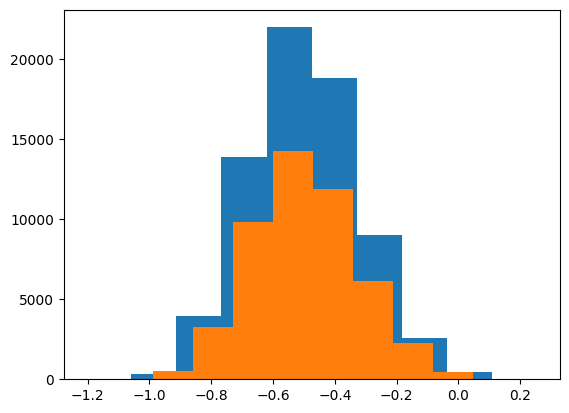

In [21]:
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

(70988, 140)

In [22]:
feature_number_pca = 75

In [53]:
X = np.hstack((X[:,:feature_number_pca],X0))
X.shape

(70988, 159)

In [54]:
meta

,day,donor,cell_type,technology
cell_id,,,,
45006fe3e4c8,2,32606,HSC,citeseq
d02759a80ba2,2,32606,HSC,citeseq
c016c6b0efa5,2,32606,EryP,citeseq
ba7f733a4f75,2,32606,NeuP,citeseq
fbcf2443ffb2,2,32606,EryP,citeseq
...,...,...,...,...
650ee456f0f3,4,31800,HSC,citeseq
cc506e7707f5,4,31800,EryP,citeseq
a91f1b55a520,4,31800,EryP,citeseq


In [25]:
import math

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization
import keras_tuner
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-11-15 08:18:10.742119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 08:18:11.229870: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


In [64]:
def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

In [65]:
LR_START = 1e-2
BATCH_SIZE = 1024

def create_model():
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(512, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    

    x0 = Dropout(DROP)(x0)
    
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)

    x1 = Dropout(DROP)(x1)
    
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1+x0) 
    

    x2 = Dropout(DROP)(x2)

    
    x3 = Dense(512,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2+x1)
    

    x3 = Dropout(DROP)(x3)

    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    x_out = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation=activation,
                )(inputs)
    
    
    x = x + x_out
    
    model = Model(inputs, x)
    

    return model

In [66]:
%%time
import warnings
warnings.filterwarnings("ignore")

EPOCHS = 1000
N_SPLITS = 3

pred_train = np.zeros((Y.shape[0],Y.shape[1]))

seed_tensorflow(1)
score_list = []
kf = GroupKFold(n_splits=N_SPLITS)
score_list = []


lr = ReduceLROnPlateau(
                monitor = "val_loss",
                factor = 0.9, 
                patience = 4, 
                verbose = VERBOSE)

es = EarlyStopping(
                monitor = "val_loss",
                patience = 100, 
                verbose = VERBOSE,
                mode = "auto", 
                restore_best_weights = True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath = './citeseq',
                save_weights_only = True,
                monitor = 'val_loss',
                mode = 'min',
                save_best_only = True)

callbacks = [   lr, 
                es, 
                model_checkpoint_callback
                ]

model = create_model()

model.compile(
            optimizer = tfa.optimizers.AdaBelief(LR_START),
            metrics = [negative_correlation_loss],
            loss = negative_correlation_loss
             )
# Training
model.fit(
            X,
            Y, 
            validation_data=(
                            X,
                            Y), 
            epochs = EPOCHS,
            verbose = 1,
            batch_size = BATCH_SIZE,
            shuffle = True,
            callbacks = callbacks)


model.load_weights('./citeseq')
model.save(f"./submissions/model_overfit")
print('model saved')

#  Model validation
y_pred = model.predict(X)

Epoch 1/1000
70/70 [==============================] - 3s 15ms/step - loss: -0.7383 - negative_correlation_loss: -0.7557 - val_loss: -0.8452 - val_negative_correlation_loss: -0.8600 - lr: 0.0100
Epoch 2/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.8620 - negative_correlation_loss: -0.8758 - val_loss: -0.8783 - val_negative_correlation_loss: -0.8904 - lr: 0.0100
Epoch 3/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.8808 - negative_correlation_loss: -0.8921 - val_loss: -0.8871 - val_negative_correlation_loss: -0.8972 - lr: 0.0100
Epoch 4/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.8869 - negative_correlation_loss: -0.8964 - val_loss: -0.8910 - val_negative_correlation_loss: -0.8995 - lr: 0.0100
Epoch 5/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.8902 - negative_correlation_loss: -0.8983 - val_loss: -0.8928 - val_negative_correlation_loss: -0.9000 - lr: 0.0100
Epoch 6/1000
70/70 [==============

70/70 [==============================] - 1s 8ms/step - loss: -0.9017 - negative_correlation_loss: -0.9042 - val_loss: -0.9029 - val_negative_correlation_loss: -0.9052 - lr: 0.0039
Epoch 86/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9018 - negative_correlation_loss: -0.9042 - val_loss: -0.9032 - val_negative_correlation_loss: -0.9055 - lr: 0.0035
Epoch 87/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9019 - negative_correlation_loss: -0.9044 - val_loss: -0.9033 - val_negative_correlation_loss: -0.9055 - lr: 0.0035
Epoch 88/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9019 - negative_correlation_loss: -0.9043 - val_loss: -0.9031 - val_negative_correlation_loss: -0.9053 - lr: 0.0035
Epoch 89/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9019 - negative_correlation_loss: -0.9044 - val_loss: -0.9031 - val_negative_correlation_loss: -0.9054 - lr: 0.0035
Epoch 90/1000
70/70 [=======================

Epoch 169/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9041 - negative_correlation_loss: -0.9063 - val_loss: -0.9056 - val_negative_correlation_loss: -0.9076 - lr: 9.8477e-04
Epoch 170/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9042 - negative_correlation_loss: -0.9065 - val_loss: -0.9057 - val_negative_correlation_loss: -0.9077 - lr: 8.8629e-04
Epoch 171/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9042 - negative_correlation_loss: -0.9065 - val_loss: -0.9057 - val_negative_correlation_loss: -0.9078 - lr: 8.8629e-04
Epoch 172/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9042 - negative_correlation_loss: -0.9065 - val_loss: -0.9057 - val_negative_correlation_loss: -0.9078 - lr: 8.8629e-04
Epoch 173/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9042 - negative_correlation_loss: -0.9065 - val_loss: -0.9057 - val_negative_correlation_loss: -0.9078 - lr: 8.8629e-04
Epoch

70/70 [==============================] - 1s 9ms/step - loss: -0.9054 - negative_correlation_loss: -0.9077 - val_loss: -0.9072 - val_negative_correlation_loss: -0.9092 - lr: 2.0276e-04
Epoch 252/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9054 - negative_correlation_loss: -0.9076 - val_loss: -0.9072 - val_negative_correlation_loss: -0.9092 - lr: 2.0276e-04
Epoch 253/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9054 - negative_correlation_loss: -0.9076 - val_loss: -0.9072 - val_negative_correlation_loss: -0.9092 - lr: 2.0276e-04
Epoch 254/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9054 - negative_correlation_loss: -0.9077 - val_loss: -0.9070 - val_negative_correlation_loss: -0.9091 - lr: 2.0276e-04
Epoch 255/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9054 - negative_correlation_loss: -0.9077 - val_loss: -0.9071 - val_negative_correlation_loss: -0.9092 - lr: 2.0276e-04
Epoch 256/1000
70/70

70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9081 - val_loss: -0.9076 - val_negative_correlation_loss: -0.9097 - lr: 3.3814e-05
Epoch 334/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9058 - negative_correlation_loss: -0.9080 - val_loss: -0.9076 - val_negative_correlation_loss: -0.9097 - lr: 3.3814e-05
Epoch 335/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9058 - negative_correlation_loss: -0.9081 - val_loss: -0.9076 - val_negative_correlation_loss: -0.9097 - lr: 3.0433e-05
Epoch 336/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9059 - negative_correlation_loss: -0.9081 - val_loss: -0.9076 - val_negative_correlation_loss: -0.9097 - lr: 3.0433e-05
Epoch 337/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9097 - lr: 3.0433e-05
Epoch 338/1000
70/70

70/70 [==============================] - 1s 8ms/step - loss: -0.9060 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.1110e-06
Epoch 416/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9060 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.1110e-06
Epoch 417/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9081 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 3.6999e-06
Epoch 418/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 3.6999e-06
Epoch 419/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 3.6999e-06
Epoch 420/1000
70/70

70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.4982e-07
Epoch 498/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.4982e-07
Epoch 499/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9081 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.4982e-07
Epoch 500/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9060 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.4982e-07
Epoch 501/1000
70/70 [==============================] - 1s 9ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.0484e-07
Epoch 502/1000
70/70

70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 5.4688e-08
Epoch 580/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 5.4688e-08
Epoch 581/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9059 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.9219e-08
Epoch 582/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9060 - negative_correlation_loss: -0.9082 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.9219e-08
Epoch 583/1000
70/70 [==============================] - 1s 8ms/step - loss: -0.9060 - negative_correlation_loss: -0.9083 - val_loss: -0.9077 - val_negative_correlation_loss: -0.9098 - lr: 4.9219e-08
Epoch 584/1000
70/70

In [67]:
y_pred = model.predict(X)

2219/2219 [==============================] - 2s 1ms/step


In [68]:
score_total = correlation_score(Y, std(y_pred))
print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

Oof corr   = 0.90998


In [69]:
score_total = correlation_score(Y, y_pred)
print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

Oof corr   = 0.90998


In [70]:
Xt = np.hstack((Xt[:,:feature_number_pca],X0t))
Xt.shape

(48663, 159)

In [71]:
X.shape

(70988, 159)

In [36]:
y_pred_t = model.predict(Xt)

1521/1521 [==============================] - 2s 1ms/step


In [38]:
test_pred_std = std(y_pred_t)

In [39]:

print("leak data test")
print(correlation_score(test_pred_std[:7476], Y[:7476]))

leak data test
0.9024454808047779


In [40]:
print("leak data test")
print(correlation_score(y_pred_t[:7476], Y[:7476]))

leak data test
0.9024454808345322


(array([   33.,   346.,  2429.,  8588., 14300., 12513.,  6594.,  2913.,
          868.,    79.]),
 array([-3.48455238, -3.10759401, -2.73063564, -2.35367751, -1.97671914,
        -1.59976077, -1.2228024 , -0.84584409, -0.46888578, -0.09192745,
         0.28503087]),
 <BarContainer object of 10 artists>)

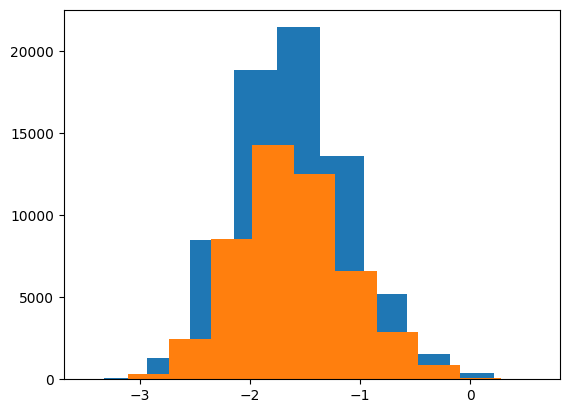

In [56]:
plt.hist(np.mean(X, axis=1))
plt.hist(np.mean(Xt, axis=1))

In [52]:
%%time
import warnings
warnings.filterwarnings("ignore")

EPOCHS = 1100
N_SPLITS = 3

pred_train = np.zeros((Y.shape[0],Y.shape[1]))

seed_tensorflow(20)
score_list = []
kf = GroupKFold(n_splits=N_SPLITS)
score_list = []

for fold, (idx_tr, idx_va) in enumerate(kf.split(X, groups=meta.donor)):
    start_time = datetime.datetime.now()
    model = None
    gc.collect()
    
    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    X_va = X[idx_va]
    y_va = Y[idx_va]

    lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)

    es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 100, 
                    verbose = VERBOSE,
                    mode = "auto", 
                    restore_best_weights = True)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './citeseq',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

    callbacks = [   lr, 
                    es, 
                    model_checkpoint_callback
                    ]
    
    model = create_model()
    
    model.compile(
                optimizer = tfa.optimizers.AdaBelief(LR_START),
                metrics = [negative_correlation_loss],
                loss = negative_correlation_loss
                 )
    # Training
    model.fit(
                X_tr,
                y_tr, 
                validation_data=(
                                X_va,
                                y_va), 
                epochs = EPOCHS,
                verbose = VERBOSE,
                batch_size = BATCH_SIZE,
                shuffle = True,
                callbacks = callbacks)

    del X_tr, y_tr 
    gc.collect()
    
    model.load_weights('./citeseq')
    model.save(f"./submissions/model_{fold}")
    print('model saved')
    
    #  Model validation
    y_va_pred = model.predict(X_va)
    corrscore = correlation_score(y_va, y_va_pred)
    pred_train[idx_va] = y_va_pred
    
    print(f"Fold {fold}, correlation =  {corrscore:.5f}")
    del X_va, y_va, y_va_pred
    gc.collect()
    score_list.append(corrscore)

# Show overall score

print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
score_total = correlation_score(Y, pred_train)
print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

INFO:tensorflow:Assets written to: ./submissions/model_0/assets
model saved
776/776 [==============================] - 1s 1ms/step
Fold 0, correlation =  0.89002
INFO:tensorflow:Assets written to: ./submissions/model_1/assets
model saved
750/750 [==============================] - 1s 1ms/step
Fold 1, correlation =  0.89519
INFO:tensorflow:Assets written to: ./submissions/model_2/assets
model saved
694/694 [==============================] - 1s 1ms/step
Fold 2, correlation =  0.89154
Mean corr = 0.89225
Oof corr   = 0.89224
CPU times: user 6min 2s, sys: 9.07 s, total: 6min 11s
Wall time: 8min 27s


In [53]:
# Standardize
def std(x):
    empty_list = []
    for item in x:
        empty_list.append((item - np.mean(item)) / np.std(item))
    return np.array(empty_list)

In [54]:
Xt = np.hstack((Xt[:,:feature_number_pca],X0t))
Xt.shape

(48663, 159)

In [39]:
test_pred = np.zeros((len(Xt), 140), dtype=np.float32)
for fold in range(N_SPLITS):
    print(f"Predicting with fold {fold}")
    model = load_model(f"./submissions/model_{fold}",
                       custom_objects={'negative_correlation_loss': negative_correlation_loss})
    test_pred += model.predict(Xt)

Predicting with fold 0
1521/1521 [==============================] - 2s 1ms/step
Predicting with fold 1
1521/1521 [==============================] - 2s 1ms/step
Predicting with fold 2
1521/1521 [==============================] - 2s 1ms/step


In [40]:
test_pred = std(test_pred)

In [41]:
print("leak data test")
print(correlation_score(test_pred[:7476], Y[:7476]))

leak data test
0.899392900022741


In [26]:
test_pred[:7476] = Y[:7476]
print(test_pred)
test_pred = std(test_pred)
print(test_pred)

[[ 9.46045294e-02 -1.62362412e-01 -4.05331880e-01 ... -2.60497332e-01
   3.83257687e-01 -1.97452575e-01]
 [-2.51250833e-01 -3.57970536e-01 -1.62689015e-01 ... -1.95552424e-01
   4.02629942e-01  2.14246258e-01]
 [-5.04534721e-01 -5.27179182e-01 -6.66114271e-01 ... -7.89938033e-01
   9.85862136e-01  6.09520316e-01]
 ...
 [-8.62916565e+01 -2.20725060e+01 -4.64350700e+01 ... -7.80430603e+01
  -5.89678841e+01  7.87515030e+01]
 [-8.09841309e+01 -6.77171555e+01 -4.02865067e+01 ... -7.46594925e+01
   2.32017578e+02  1.02085007e+02]
 [-7.74072113e+01 -6.09491806e+01 -3.83022118e+01 ... -7.22794113e+01
   2.72235046e+02  1.15302826e+02]]
[[ 0.09460448 -0.16236246 -0.40533194 ... -0.2604974   0.38325763
  -0.19745262]
 [-0.2512508  -0.3579705  -0.16268899 ... -0.1955524   0.40262997
   0.21424629]
 [-0.50453466 -0.5271791  -0.6661142  ... -0.789938    0.9858622
   0.6095204 ]
 ...
 [-0.40628484 -0.06481007 -0.19435398 ... -0.36242428 -0.26099515
   0.471305  ]
 [-0.5943697  -0.49119973 -0.2778867

In [27]:
submission = pd.read_csv("/ysm-gpfs/pi/zhao/tl688/openproblems/submission_testourcite.csv",index_col='row_id', squeeze=True)
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()

submission.to_csv('submission_onebestcite_cpu.csv')
display(submission)

row_id
0           0.094604
1          -0.162362
2          -0.405332
3          -0.302582
4           1.114355
              ...   
65744175    2.777528
65744176   -0.369145
65744177   -0.367802
65744178    0.135783
65744179    2.558738
Name: target, Length: 65744180, dtype: float64

In [18]:
test_pred = np.zeros((len(Xt), 140), dtype=np.float32)
for fold in range(N_SPLITS):
    print(f"Predicting with fold {fold}")
    model = load_model(f"./submissions/model_{fold}",
                       custom_objects={'negative_correlation_loss': negative_correlation_loss})
    test_pred += model.predict(Xt)

# Copy the targets for the data leak but useless since the change in the public LB...
test_pred[:7476] = Y[:7476]

Predicting with fold 0


ValueError: in user code:

    File "/gpfs/ysm/project/zhao/tl688/conda_envs/tf117/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/gpfs/ysm/project/zhao/tl688/conda_envs/tf117/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/gpfs/ysm/project/zhao/tl688/conda_envs/tf117/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/gpfs/ysm/project/zhao/tl688/conda_envs/tf117/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/gpfs/ysm/project/zhao/tl688/conda_envs/tf117/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/gpfs/ysm/project/zhao/tl688/conda_envs/tf117/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 159), found shape=(None, 512)


In [18]:
%%time
# test seed
import warnings
warnings.filterwarnings("ignore")

EPOCHS = 1100
N_SPLITS = 3

for seed in range(20,30):
    print(seed)
    pred_train = np.zeros((Y.shape[0],Y.shape[1]))

    seed_tensorflow(seed)
    score_list = []
    kf = GroupKFold(n_splits=N_SPLITS)
    score_list = []

    for fold, (idx_tr, idx_va) in enumerate(kf.split(X, groups=meta.donor)):
        start_time = datetime.datetime.now()
        model = None
        gc.collect()

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]
        X_va = X[idx_va]
        y_va = Y[idx_va]

        lr = ReduceLROnPlateau(
                        monitor = "val_loss",
                        factor = 0.9, 
                        patience = 4, 
                        verbose = VERBOSE)

        es = EarlyStopping(
                        monitor = "val_loss",
                        patience = 100, 
                        verbose = VERBOSE,
                        mode = "auto", 
                        restore_best_weights = True)

        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath = './citeseq',
                        save_weights_only = True,
                        monitor = 'val_loss',
                        mode = 'min',
                        save_best_only = True)

        callbacks = [   lr, 
                        es, 
                        model_checkpoint_callback
                        ]

        model = create_model()

        model.compile(
                    optimizer = tfa.optimizers.AdaBelief(LR_START),
                    metrics = [negative_correlation_loss],
                    loss = negative_correlation_loss
                     )
        # Training
        model.fit(
                    X_tr,
                    y_tr, 
                    validation_data=(
                                    X_va,
                                    y_va), 
                    epochs = EPOCHS,
                    verbose = VERBOSE,
                    batch_size = BATCH_SIZE,
                    shuffle = True,
                    callbacks = callbacks)

        del X_tr, y_tr 
        gc.collect()

        model.load_weights('./citeseq')
        model.save(f"./submissions/model_{fold}_{seed}")
        print('model saved')

        #  Model validation
        y_va_pred = model.predict(X_va)
        corrscore = correlation_score(y_va, y_va_pred)
        pred_train[idx_va] = y_va_pred

        print(f"Fold {fold}, correlation =  {corrscore:.5f}")
        del X_va, y_va, y_va_pred
        gc.collect()
        score_list.append(corrscore)

    # Show overall score

    print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(score_list).mean():.5f}{Style.RESET_ALL}")
    score_total = correlation_score(Y, pred_train)
    print(f"{Fore.BLUE}{Style.BRIGHT}Oof corr   = {score_total:.5f}{Style.RESET_ALL}")

20
INFO:tensorflow:Assets written to: ./submissions/model_0_20/assets
model saved
776/776 [==============================] - 1s 1ms/step
Fold 0, correlation =  0.89232
INFO:tensorflow:Assets written to: ./submissions/model_1_20/assets
model saved
750/750 [==============================] - 1s 1ms/step
Fold 1, correlation =  0.89699
INFO:tensorflow:Assets written to: ./submissions/model_2_20/assets
model saved
694/694 [==============================] - 1s 1ms/step
Fold 2, correlation =  0.89415
Mean corr = 0.89449
Oof corr   = 0.89447
21
INFO:tensorflow:Assets written to: ./submissions/model_0_21/assets
model saved
776/776 [==============================] - 1s 1ms/step
Fold 0, correlation =  0.89192
INFO:tensorflow:Assets written to: ./submissions/model_1_21/assets
model saved
750/750 [==============================] - 1s 999us/step
Fold 1, correlation =  0.89730
INFO:tensorflow:Assets written to: ./submissions/model_2_21/assets
model saved
694/694 [==============================] - 1s 9

In [92]:
Xt = np.hstack((Xt[:,:feature_number_pca],X0t))
Xt.shape

(48663, 159)

In [54]:
test_pred = np.zeros((len(Xt), 140), dtype=np.float32)
for fold in range(N_SPLITS):
    print(f"Predicting with fold {fold}")
    model = load_model(f"./submissions/model_{fold}",
                       custom_objects={'negative_correlation_loss': negative_correlation_loss})
    test_pred += model.predict(Xt)

# Copy the targets for the data leak but useless since the change in the public LB...
test_pred[:7476] = Y[:7476]

# from Juan Smith Perera to complete with the Multiome part :
# submission = pd.read_csv('submission_lolo_1.csv',index_col='row_id', squeeze=True)
submission = pd.read_csv('submission.csv',index_col='row_id', squeeze=True)
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()

submission.to_csv('submission.csv')
display(submission)

Predicting with fold 0
1378/1521 [==========================>...] - ETA: 0s


KeyboardInterrupt



In [16]:
len(Xt)

48663

In [24]:
submit_atac = pd.read_csv("./openproblems/ensemble_eri812.csv", index_col=0) #your result 0.812
submit_cite = pd.read_csv("./openproblems/submission.csv", index_col=0) #my result 0.813

submit_atac.iloc[0:len(Xt)] = submit_cite.iloc[0:len(Xt)].copy()

submit_atac.to_csv("submission_ensemble.csv")

In [26]:
with open('./input/targets-multiome-sparse-scaled/INDEX_train_multiome.pkl','rb') as f: INDEX_train_multiome = pickle.load(f)
with open('./input/targets-multiome-sparse-scaled/train_512.pkl','rb') as f: X = pickle.load(f)
with open('./input/targets-multiome-sparse-scaled/pca_train_512.pkl','rb') as f: pca_train = pickle.load(f)
with open('./input/targets-multiome-sparse-scaled/pca_target_512.pkl','rb') as f: pca_target = pickle.load(f)
with open('./input/targets-multiome-sparse-scaled/Y_512.pkl','rb') as f: Y = pickle.load(f)
    
# # for ga
# with open('./input/targets-multiome-sparse-scaled/INDEX_train_multiome.pkl','rb') as f: INDEX_train_multiome = pickle.load(f)
# with open('./input/targets-multiome-sparse-scaled/train_ga_512.pkl','rb') as f: X = pickle.load(f)
# with open('./input/targets-multiome-sparse-scaled/pca_train_ga_512.pkl','rb') as f: pca_train = pickle.load(f)
# with open('./input/targets-multiome-sparse-scaled/pca_target_512.pkl','rb') as f: pca_target = pickle.load(f)
# with open('./input/targets-multiome-sparse-scaled/Y_512.pkl','rb') as f: Y = pickle.load(f)

In [36]:
feature_num_multi = 40 #original: 40

In [37]:
X = X[:,:feature_num_multi]
X.shape

(105942, 40)

In [38]:
metadata_df = pd.read_csv('metadata.csv',index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(INDEX_train_multiome)

In [39]:
LR_START = 1e-3
BATCH_SIZE = 512

def create_model():
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(512, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    

    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    

    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1+x0)
    

    x2= Dropout(DROP)(x2)
    
    x3 = Dense(Y.shape[1],
               kernel_regularizer = REG1,
               activation = activation,
             )(x2+x1)
    

    x3 = Dropout(DROP)(x3)

    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
       
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    x_out = Dense(Y.shape[1], 
            kernel_regularizer = REG2,
            activation='linear',
            )(inputs)
    
    x = x + x_out
    
    
    model = Model(inputs, x)
    

    return model

# #original model
# LR_START = 1e-3
# BATCH_SIZE = 512

# def create_model():
    
#     reg1 = 9.613e-06
#     reg2 = 1e-07
#     REG1 = tf.keras.regularizers.l2(reg1)
#     REG2 = tf.keras.regularizers.l2(reg2)
#     DROP = 0.1

#     activation = 'selu'
#     inputs = Input(shape =(X.shape[1],))

#     x0 = Dense(256, 
#               kernel_regularizer = REG1,
#               activation = activation,
#              )(inputs)
#     x0 = Dropout(DROP)(x0)
    
    
#     x1 = Dense(512, 
#                kernel_regularizer = REG1,
#                activation = activation,
#              )(x0)
#     x1 = Dropout(DROP)(x1)
    
    
#     x2 = Dense(512, 
#                kernel_regularizer = REG1,
#                activation = activation,
#              )(x1) 
#     x2= Dropout(DROP)(x2)
    
#     x3 = Dense(Y.shape[1],
#                kernel_regularizer = REG1,
#                activation = activation,
#              )(x2)
#     x3 = Dropout(DROP)(x3)

         
#     x = Concatenate()([
#                 x0, 
#                 x1, 
#                 x2, 
#                 x3
#                 ])
    
#     x = Dense(Y.shape[1], 
#                 kernel_regularizer = REG2,
#                 activation='linear',
#                 )(x)
    
    
#     model = Model(inputs, x)
    

#     return model

In [40]:
def create_model_tuning(hp, n_inputs=X.shape[1]):
    
#     reg1 = 9.613e-06
#     reg2 = 1e-07
    reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
    reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(512, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    

    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    

    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1+x0)
    

    x2= Dropout(DROP)(x2)
    
    x3 = Dense(Y.shape[1],
               kernel_regularizer = REG1,
               activation = activation,
             )(x2+x1)
    

    x3 = Dropout(DROP)(x3)

    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
       
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    x_out = Dense(Y.shape[1], 
            kernel_regularizer = REG2,
            activation='linear',
            )(inputs)
    
    x = Dense(Y.shape[1], 
            kernel_regularizer = REG2,
            activation='linear',
            )(x+x_out)
    
    model = Model(inputs, x)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('best_lr', [1e-2, 1e-3, 1e-4])),
                    metrics=[negative_correlation_loss],
                      loss="mse")
    
    

    return model

In [41]:
TUNE = False

In [42]:
%%time
if TUNE:
    tuner = keras_tuner.BayesianOptimization(
        create_model_tuning,
        overwrite=True,
        objective=keras_tuner.Objective("val_negative_correlation_loss", direction="min"),
        max_trials=100,
        directory='./temp_kaggle',
        seed=1)
    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                           patience=4, verbose=0)
    es = EarlyStopping(monitor="val_loss",
                       patience=12, 
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]
    X_tr, X_va, y_tr, y_va = train_test_split(X, Y, test_size=0.2, random_state=10)
    tuner.search(X_tr, y_tr,
                 epochs=500,
                 validation_data=(X_va, y_va),
                 batch_size=BATCH_SIZE,
                 callbacks=callbacks, verbose=2)
    del X_tr, X_va, y_tr, y_va, lr, es, callbacks

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 23.4 µs


In [43]:
if TUNE:
    tuner.results_summary()
    
    # Table of the 10 best trials
    display(pd.DataFrame([hp.values for hp in tuner.get_best_hyperparameters(10)]))
    
    # Keep the best hyperparameters
    best_hp = tuner.get_best_hyperparameters(1)[0]

In [44]:
%%time
import warnings
warnings.filterwarnings("ignore")

N_SPLIT = 3


# np.random.seed(1)
# tf.random.set_seed(1)
seed_tensorflow()

#kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
kf = GroupKFold(n_splits = N_SPLIT)

for fold,(idx_tr, idx_va) in enumerate(kf.split(X,groups=meta.donor)):
    
    X_tr = X[idx_tr]
    y_tr = Y[idx_tr]
    
    X_va = X[idx_va]
    y_va = Y[idx_va] 
    
    model = create_model()
    
    lr = ReduceLROnPlateau(
                monitor = "val_loss",
                factor = 0.9, 
                patience = 4, 
                verbose = VERBOSE)
    
    es = EarlyStopping(
                monitor = "val_loss",
                patience = 100, 
                verbose = VERBOSE,
                mode = "min", 
                restore_best_weights = True)

    model.compile(optimizer= tfa.optimizers.AdaBelief(learning_rate=LR_START),
                  loss = 'mse',
                  metrics=None)
    model.fit(X_tr,
              y_tr,
              validation_data=(X_va,y_va),
              epochs =3500, 
              verbose = VERBOSE,
              batch_size=BATCH_SIZE,
              callbacks = [es,lr]
             )
    pred = model.predict(X_va)
    
    print(f'\n --------- FOLD {fold} -----------')
    print(f'Mean squared error = {np.round(mean_squared_error(y_va,pred),2)}')
    print(f'correlation value = {np.round(correlation_score(y_va,pred),2)}')
   
    filename = f"model_{fold}"
    model.save(filename)
    print('model saved :',filename)
        
    del X_tr,X_va,y_tr,y_va
    gc.collect()


1152/1152 [==============================] - 1s 963us/step

 --------- FOLD 0 -----------
Mean squared error = 3.299999952316284
correlation value = 0.92
INFO:tensorflow:Assets written to: model_0/assets
model saved : model_0
1107/1107 [==============================] - 1s 955us/step

 --------- FOLD 1 -----------
Mean squared error = 3.1700000762939453
correlation value = 0.93
INFO:tensorflow:Assets written to: model_1/assets
model saved : model_1
1054/1054 [==============================] - 1s 963us/step

 --------- FOLD 2 -----------
Mean squared error = 3.200000047683716
correlation value = 0.93
INFO:tensorflow:Assets written to: model_2/assets
model saved : model_2
CPU times: user 12min 32s, sys: 41.5 s, total: 13min 14s
Wall time: 15min 32s


In [ ]:
multi_test_x = scipy.sparse.load_npz("./input/multimodal-single-cell-as-sparse-matrix/test_multi_inputs_values.sparse.npz")
multi_test_x = pca_train.transform(multi_test_x)
multi_test_x = multi_test_x[:,:feature_num_multi]
multi_test_x.shape

In [ ]:
# adata = sc.read_h5ad("test_multi_ga.h5ad")
# multi_test_x = adata.X.copy()
# multi_test_x = pca_train.transform(multi_test_x)
# multi_test_x = multi_test_x[:,:feature_num_multi]
# multi_test_x.shape

# adata = pd.read_h5("./input/multimodal-single-cell-as-sparse-matrix/test_multi_geneactivity.h5")
# multi_test_x = adata.values
# multi_test_x = pca_train.transform(multi_test_x)
# multi_test_x = multi_test_x[:,:feature_num_multi]
# multi_test_x.shape

In [41]:
preds = np.zeros((multi_test_x.shape[0], 23418), dtype='float16')

for fold in range(N_SPLIT):
    print(f'fold {fold} prediction')
    model = tf.keras.models.load_model(f"model_{fold}")
    preds += (model.predict(multi_test_x)@pca_target.components_)/N_SPLIT

    gc.collect()

fold 0 prediction
1748/1748 [==============================] - 2s 1ms/step
fold 1 prediction
1748/1748 [==============================] - 2s 1ms/step
fold 2 prediction
1748/1748 [==============================] - 2s 1ms/step


In [ ]:
# !pip install pyarrow fastparquet

In [22]:
eval_ids = pd.read_parquet("./input/multimodal-single-cell-as-sparse-matrix/evaluation.parquet")
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

submission = pd.Series(name='target',
                       index=pd.MultiIndex.from_frame(eval_ids), 
                       dtype=np.float32)
submission

row_id    cell_id       gene_id        
0         c2150f55becb  CD86              NaN
1         c2150f55becb  CD274             NaN
2         c2150f55becb  CD270             NaN
3         c2150f55becb  CD155             NaN
4         c2150f55becb  CD112             NaN
                                           ..
65744175  2c53aa67933d  ENSG00000134419   NaN
65744176  2c53aa67933d  ENSG00000186862   NaN
65744177  2c53aa67933d  ENSG00000170959   NaN
65744178  2c53aa67933d  ENSG00000107874   NaN
65744179  2c53aa67933d  ENSG00000166012   NaN
Name: target, Length: 65744180, dtype: float32

In [23]:
y_columns = np.load("./input/multimodal-single-cell-as-sparse-matrix/train_multi_targets_idxcol.npz",
                   allow_pickle=True)["columns"]

test_index = np.load("./input/multimodal-single-cell-as-sparse-matrix/test_multi_inputs_idxcol.npz",
                    allow_pickle=True)["index"]

cell_dict = dict((k,v) for v,k in enumerate(test_index)) 
assert len(cell_dict)  == len(test_index)

gene_dict = dict((k,v) for v,k in enumerate(y_columns))
assert len(gene_dict) == len(y_columns)

eval_ids_cell_num = eval_ids.cell_id.apply(lambda x:cell_dict.get(x, -1))
eval_ids_gene_num = eval_ids.gene_id.apply(lambda x:gene_dict.get(x, -1))
valid_multi_rows = (eval_ids_gene_num !=-1) & (eval_ids_cell_num!=-1)

submission.iloc[valid_multi_rows] = preds[eval_ids_cell_num[valid_multi_rows].to_numpy(),
eval_ids_gene_num[valid_multi_rows].to_numpy()]

del eval_ids_cell_num, eval_ids_gene_num, valid_multi_rows, eval_ids, test_index, y_columns
gc.collect()

submission

row_id    cell_id       gene_id        
0         c2150f55becb  CD86                    NaN
1         c2150f55becb  CD274                   NaN
2         c2150f55becb  CD270                   NaN
3         c2150f55becb  CD155                   NaN
4         c2150f55becb  CD112                   NaN
                                             ...   
65744175  2c53aa67933d  ENSG00000134419    2.751953
65744176  2c53aa67933d  ENSG00000186862   -0.379150
65744177  2c53aa67933d  ENSG00000170959   -0.376465
65744178  2c53aa67933d  ENSG00000107874    0.179321
65744179  2c53aa67933d  ENSG00000166012    2.480469
Name: target, Length: 65744180, dtype: float32

In [24]:
submission.reset_index(drop=True, inplace=True)
submission.index.name = 'row_id'

# cite_submission = pd.read_csv("submission_lolo_1.csv")
cite_submission = pd.read_csv("submission.csv")
cite_submission = cite_submission.set_index("row_id")
cite_submission = cite_submission["target"]
submission[submission.isnull()] = cite_submission[submission.isnull()]
submission
# == > score 0.812

row_id
0           0.094605
1          -0.162362
2          -0.405332
3          -0.302582
4           1.114355
              ...   
65744175    2.751953
65744176   -0.379150
65744177   -0.376465
65744178    0.179321
65744179    2.480469
Name: target, Length: 65744180, dtype: float64

In [25]:
submission.to_csv("submission.csv")

In [24]:
# submission1.to_csv("submission_emsemb_pre.csv")

# File submission

In [5]:
submssion_sample = pd.read_csv("evaluation_ids.csv")

In [6]:
submission = pd.read_csv("submission_testourcite.csv", index_col=0)

In [7]:
submission_copy =submission.copy() 

In [8]:
cor_list = pd.read_csv("citeseq_worest_test_metadata.csv", index_col=0)

In [9]:
cor_list

,protein,index,correlation,index_protein
0,CD272,0.540208,0.540208,66
1,KLRG1,0.548423,0.548423,52
2,CD72,0.500206,0.500206,115
3,CD18,0.464988,0.464988,102
4,CD107a,0.413140,0.413140,54
...,...,...,...,...
95,Rat-IgG2b,0.331818,0.331818,34
96,CD11b,0.324618,0.324618,59
97,Mouse-IgG2b,0.321988,0.321988,33
98,TCRVd2,0.320435,0.320435,123


In [10]:
submission = submission[0:6812820]
submssion_sample = submssion_sample[0:6812820]

In [11]:
submission["cell_id"] = submssion_sample["cell_id"]

In [12]:
from tqdm.notebook import tqdm

In [13]:
# Standardize submission per cell_id
loop_list          = submission.groupby('cell_id', sort=False)
vals               = []

for idx, g in tqdm(loop_list, desc=f'Standardizing', miniters=1000):
    vals.append(g.target.values)

to_save_norm = np.concatenate(vals)

Standardizing:   0%|          | 0/48663 [00:00<?, ?it/s]

In [14]:
vals = np.array(vals)

In [15]:
vals

array([[ 9.46044826e-02, -1.62362460e-01, -4.05331930e-01, ...,
        -2.60497381e-01,  3.83257642e-01, -1.97452624e-01],
       [-2.51250784e-01, -3.57970479e-01, -1.62688971e-01, ...,
        -1.95552378e-01,  4.02629948e-01,  2.14246277e-01],
       [-5.04534627e-01, -5.27179086e-01, -6.66114169e-01, ...,
        -7.89937925e-01,  9.85862162e-01,  6.09520360e-01],
       ...,
       [-4.25168289e-01, -7.80186930e-04, -2.21839650e-01, ...,
        -3.80482556e-01, -2.60563119e-01,  4.08056145e-01],
       [-6.14958595e-01, -5.03246575e-01, -2.44184170e-01, ...,
        -5.44253405e-01,  2.02915635e+00,  9.25770420e-01],
       [-5.89724067e-01, -4.47030269e-01, -2.50559143e-01, ...,
        -5.40320414e-01,  2.24419000e+00,  1.06924650e+00]])

In [16]:
test_worst_prot = np.load("citeseq_generation_wor_test.npy")

In [17]:
test_worst_prot.shape

(48663, 100)

In [18]:
vals_output = vals.copy()

In [19]:
vals[:,0]

array([ 0.09460448, -0.25125078, -0.50453463, ..., -0.42516829,
       -0.61495859, -0.58972407])

In [20]:
vals_output[:,0]

array([ 0.09460448, -0.25125078, -0.50453463, ..., -0.42516829,
       -0.61495859, -0.58972407])

In [21]:
for i in range(test_worst_prot.shape[1]):
    vals_output[:,cor_list["index_protein"][i]] = test_worst_prot[:,i]

In [30]:
submission_copy

,target
row_id,
0,0.094604
1,-0.162362
2,-0.405332
3,-0.302582
4,1.114355
...,...
65744175,2.777528
65744176,-0.369145
65744177,-0.367802


In [31]:
submission_copy["target"].iloc[:len(vals_output.ravel())] = vals_output.ravel()

In [35]:
submission_copy

,target
row_id,
0,1.677447
1,0.788923
2,-0.051202
3,-0.302582
4,1.114355
...,...
65744175,2.777528
65744176,-0.369145
65744177,-0.367802


In [36]:
submission_copy.to_csv("submission_update_worstprotein.csv")

In [35]:
sub_load = pd.read_csv("submission_update_worstprotein.csv", index_col=0)

In [37]:
sub_load.shape

(6812820, 1)

In [ ]:
submission[0:6812820] = submission[0:6812820]
submssion_sample[0:6812820] = submssion_sample[0:6812820]

In [ ]:
# Standardize submission per cell_id
loop_list          = submission.groupby('cell_id', sort=False)
vals               = []

for idx, g in tqdm(loop_list, desc=f'Standardizing', miniters=1000):
    vals.append(std(g.target).values)

to_save_norm = np.concatenate(vals)

In [17]:
submission = pd.read_csv("./openproblems/submission_correct_multi.csv", index_col=0)

In [18]:
submission_cite = pd.read_csv("./openproblems/submission_10combine_wrongmulti.csv", index_col=0)

In [20]:
submission_cite

,target
row_id,
0,0.094604
1,-0.162362
2,-0.405332
3,-0.302582
4,1.114355
...,...
65744175,4.406590
65744176,-0.603898
65744177,-0.595424


In [21]:
submission[0:6812820] = submission_cite[0:6812820]
submission[0:6812820] = submission_cite[0:6812820]

In [22]:
submission.to_csv("submission_10_combine.csv")

In [26]:
submission["cell_id"] = submssion_sample["cell_id"]

In [27]:
submission

,target,cell_id
row_id,,
0,0.104065,c2150f55becb
1,-0.178599,c2150f55becb
2,-0.445865,c2150f55becb
3,-0.332840,c2150f55becb
4,1.225791,c2150f55becb
...,...,...
65744175,4.847249,2c53aa67933d
65744176,-0.664288,2c53aa67933d
65744177,-0.654967,2c53aa67933d


In [28]:
# Standardize submission per cell_id
loop_list          = submission.groupby('cell_id', sort=False)
vals               = []

for idx, g in tqdm(loop_list, desc=f'Standardizing', miniters=1000):
    vals.append(std(g.target).values)

to_save_norm = np.concatenate(vals)

Standardizing:   0%|          | 0/65443 [00:00<?, ?it/s]

In [29]:
to_save_norm

array([ 0.09460448, -0.16236246, -0.40533193, ..., -0.59542426,
        0.2248275 ,  3.91355303])

In [30]:
submission['target'] = to_save_norm

In [31]:
del submission['cell_id']

In [32]:
submission

,target
row_id,
0,0.094604
1,-0.162362
2,-0.405332
3,-0.302582
4,1.114355
...,...
65744175,4.406590
65744176,-0.603898
65744177,-0.595424


In [33]:
submission.to_csv("submission_10_pca_combine.csv")

In [34]:
submission

,target
row_id,
0,0.094604
1,-0.162362
2,-0.405332
3,-0.302582
4,1.114355
...,...
65744175,4.406590
65744176,-0.603898
65744177,-0.595424
